In [1]:
import pandas as pd
import os

In [2]:
import networkx as nx

## Flight Route Data Ingest

In [3]:
# data from https://www.partow.net/miscellaneous/airportdatabase/index.html#Downloads
data_folder = "/Users/heidihurst/Documents/Maps/az_map_challenge/ty/data/"

In [4]:
airport_location_path = os.path.join(data_folder, 
                                     "GlobalAirportDatabase/GlobalAirportDatabase.txt")
airport_location_columns = ["icao", "iata", "name", "city", "country", 
                            "lat_deg", "lat_min", "lat_sec", "lat_dir",
                            "lon_deg", "lon_min", "lon_sec", "lon_dir",
                            "alt", "lat", "lon"
                           ]

In [5]:
airport_data = pd.read_csv(airport_location_path, delimiter=":", 
                           names=airport_location_columns)
airport_data = airport_data[pd.notna(airport_data["iata"])]
airport_data = airport_data.drop_duplicates(subset="iata")
airport_data = airport_data.set_index("iata")

In [6]:
# data from https://github.com/jpatokal/openflights/blob/master/data/routes.dat
# see also https://openflights.org/data.html#route
route_data_path = os.path.join(data_folder, "routes.dat")

In [7]:
route_data_columns = ["airline", "airline_id", "source", "source_id", "dest", "dest_id",
                     "codeshare", "stops", "plane"]

In [8]:
route_data = pd.read_csv(route_data_path, names=route_data_columns)

## Add Distance

In [9]:
# add haversine distance

In [10]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [11]:
def haversine_airport(source, dest, airport_data=airport_data):
    source_lon = airport_data.loc[source]["lon"]
    source_lat = airport_data.loc[source]["lat"]
    dest_lon = airport_data.loc[dest]["lon"]
    dest_lat = airport_data.loc[dest]["lat"]
    return haversine(source_lon, source_lat, dest_lon, dest_lat)

In [12]:
fails = []
for row in route_data.iterrows():
    try:
        dist = haversine_airport(row[1]["source"], row[1]["dest"])
        route_data.at[row[0], "dist"] = dist
    except Exception:
        fails.append(row[0])

## Graph Creation & Cleaning

In [13]:
# create graph
g = nx.from_pandas_edgelist(route_data, "source", "dest", 
                            edge_attr=True, create_using=nx.DiGraph)
# add attributes
nx.set_node_attributes(g, airport_data.to_dict('index'))

In [14]:
# get ride of nodes without attributes
bad_nodes = [n for n in g.nodes if len(g.nodes[n].keys()) == 0]
_ = [g.remove_node(n) for n in bad_nodes]

In [15]:
# we want to consider any paths between the phoenix area and london, 
# so we get all relevant airports and merge them
# no data for AZA (mesa gateway) in airport data, so it's not present here
# g = nx.contracted_nodes(G, "PHX", "AZA", self_loops = False) 

In [16]:
# merge all london airports into heathrow
london = list(airport_data.loc[(airport_data.city == "LONDON") & 
                            (airport_data.country == "ENGLAND")].index)

In [17]:
for airport in london[1:]:
    g = nx.contracted_nodes(g, london[0], airport, self_loops = False)

In [18]:
# clean up heathrow with london coordinates
nx.set_node_attributes(g, {"LHR":{"lon":-0.1278, "lat":51.5074}})

In [86]:
# create dict of positions based on lat/lon
pos = {}
for node in g.nodes:
    try:
        pos[node] = (g.nodes[node]["lon"], g.nodes[node]["lat"])
    except KeyError:
        print(f"Can't find coords for {node} with params {g.nodes[node].keys()}")

## Visualize

In [22]:
import matplotlib.pyplot as plt

In [23]:
undir_g = g.to_undirected()

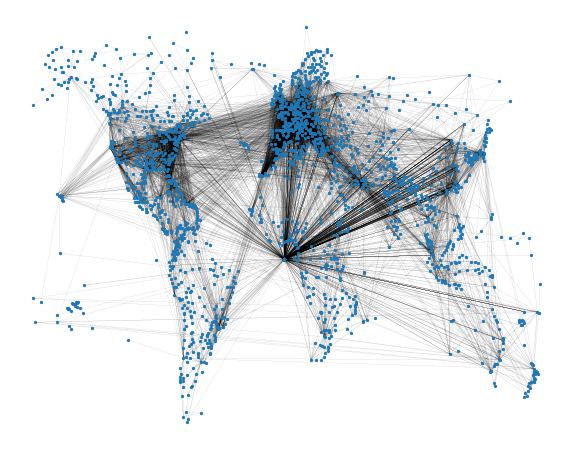

In [26]:
fix, ax = plt.subplots(figsize=(10,8))
nx.draw(undir_g, pos, node_size=5, width=.05, connectionstyle='arc3,rad=4')
plt.show()

## Routing

In [27]:
# find flights between me and tyler less than cutoff number of legs
cutoff = 4
short_paths = nx.all_simple_paths(g, "PHX", "LHR", cutoff = cutoff)
short_paths = list(short_paths)

In [28]:
def route_key(route):
    return "_".join(route)

def route_tuple(route):
    return [(route[i], route[i+1]) for i in range(len(route)-1)]

def route_length(route_tuple):
    return sum([g.edges[route_leg]["dist"] for route_leg in route_tuple])

def unique_lists(input_list):
    output = {}
    for item in input_list:
        key = route_key(item)
        if key not in output:
            route = route_tuple(item)
            output[key] = {"num": 1, "route": route, 
                           "legs":len(item)-1, "dist": route_length(route)}
        else:
            output[key]["num"] += 1
    return output

In [29]:
path_info_dict = unique_lists(short_paths)
paths = [p[1]["route"] for p in path_info_dict.items()]

In [30]:
path_info = pd.DataFrame.from_dict(path_info_dict, orient='index').sort_values("dist").sort_values("legs")

In [31]:
# break distance into bins because idk it's being annoying
nbins = 2000
path_info["binned"] = pd.cut(path_info["dist"], nbins)

In [39]:
traversed_edges_list = path_info.route.values

In [42]:
traversed_edges = {}
for tl in traversed_edges_list:
    for edge in tl:
        if edge not in traversed_edges:
            traversed_edges[edge] = 1
        else:
            traversed_edges[edge] += 1

In [48]:
traversed_edges_df = pd.DataFrame.from_dict(traversed_edges, 
                                            orient="index", 
                                            columns=["count"])

## Visualization

In [57]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [58]:
color_map = "Greens"
cmap = cm.get_cmap(color_map)

### Approach 1: By Route

In [59]:
# NOTE: using all routes, or even a subset, results in weird color behavior
# using more than ~2k routes results in colors outside of the provided cmap
# being displayed, even _despite_ the normaliation introduced below

# num_routes = len(path_info)
num_routes = 1000
scale_width = 2
max_dist = max(path_info[0:num_routes]["dist"])#/scale_width
min_dist = min(path_info[0:num_routes]["dist"])#/scale_width
norm = Normalize(min_dist, max_dist)

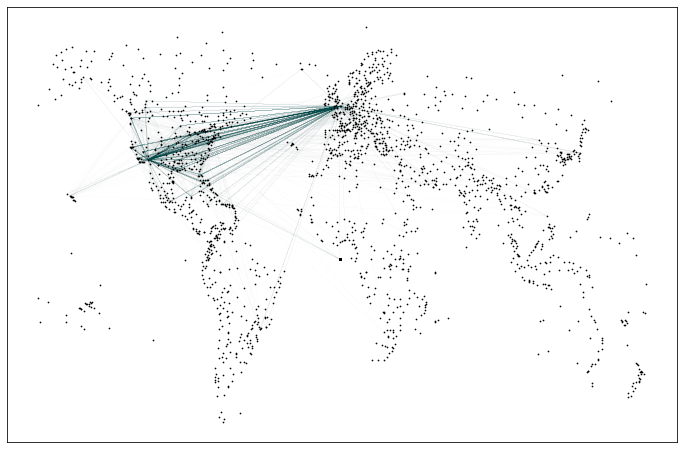

In [62]:
fig, ax = plt.subplots(figsize=(12,8))

nx.draw_networkx_nodes(undir_g, pos, node_size=0.5, node_color="black")

for row in path_info[0:num_routes].iterrows():
    nx.draw_networkx_edges(undir_g, pos, edgelist=row[1]["route"], 
                           connectionstyle="arc3, rad=0.3",
#                            edge_color=cmap((i%256)/256),  
#                            edge_color=cmap(norm(row[1]["dist"])),
#                            edge_color=row[1]["binned"], 
                           edge_color="xkcd:dark teal",
                           width=0.01)
plt.show()

### Approach 2: By Frequency

In [90]:
max_trav = max(traversed_edges_df["count"])
min_trav = min(traversed_edges_df["count"])
norm = Normalize(min_trav/4, max_trav)

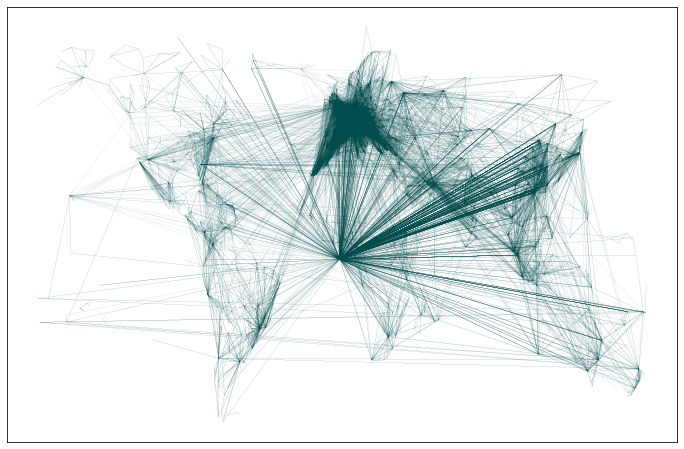

In [96]:
fig, ax = plt.subplots(figsize=(12,8))

nx.draw_networkx_nodes(undir_g, pos, node_size=0, node_color="black")

for edge in g.edges:
    nx.draw_networkx_edges(undir_g, pos, edgelist=[edge], 
                           connectionstyle="arc3, rad=1", # doesn't seem to work
                           edge_color="xkcd:dark teal",
                           alpha=norm(traversed_edges.get(edge, max_dist)),
                           width=0.05)

plt.savefig("null_island.png", dpi=500)
plt.show()